In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

import os 
import time

from renewable_data_load import *

from threshold_tools import *

# Configure dask for parallel execution
#import dask
#dask.config.set(scheduler='threads', num_workers=10)  # Adjust num_workers to your CPU cores

In [ ]:
ds_doy.isel(x=110,y=230).plot(x='year',y='dayofyear', cmap='viridis')

drought_ds.isel(x=110,y=230).plot(x='year',y='dayofyear', cmap='viridis')

NameError: name 'ds_doy' is not defined

In [6]:
resource = "pv"
module = "utility"
domain = "d02"
variable = "cf"
frequency = "day"
simulation = "taiesm1"
reference_gwl = 0.8
future_gwl = 2.0

window_size = 60

simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", 'ec-earth3',]
#simulations = ['ec-earth3']


In [7]:
for simulation in simulations:
    threshold_file = f"../data/thresholds/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_10th_pctile.nc"
    drought_threshold_ds = xr.open_dataset(threshold_file)
    ren_ds = get_ren_data_concat(resource, module, domain, variable, frequency, simulation)
    ren_ds = ren_ds.convert_calendar("noleap")

    # reshape array
    ds_doy = ren_ds.copy(deep=True)
    ds_doy['dayofyear'] = ds_doy.time.dt.dayofyear
    ds_doy['year'] = ds_doy.time.dt.year
    ds_doy = ds_doy.assign_coords(
        {"dayofyear":ds_doy.time.dt.dayofyear,
        "year":ds_doy.time.dt.year}
    )
    # reshape time dimension
    ds_doy = ds_doy.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

    drought_ds = (ds_doy - drought_threshold_ds.reference_gen).load()

    # reshape back into daily timeseries
    drought_ds = drought_ds.stack(time=['year','dayofyear'])
    drought_ds = drought_ds.reset_index("time").assign_coords(time=ren_ds.time)

    drought_ds = drought_ds.load()

    # Create binary drought mask for entire time series
    # 1 where drought_ds < 0 (below threshold), 0 otherwise
    drought_mask = xr.where(drought_ds < 0, 1, 0)
    drought_mask.name = "drought_mask"

    # save into the drought mask folder

    drought_mask = drought_mask.load()

    # Save drought mask to file
    mask_output_file = f"../data/drought_masks/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_drought_mask_only.nc"

    # Add metadata to drought mask
    drought_mask.attrs['resource'] = resource
    drought_mask.attrs['module'] = module
    drought_mask.attrs['domain'] = domain
    drought_mask.attrs['variable'] = variable
    drought_mask.attrs['simulation'] = simulation
    drought_mask.attrs['reference_gwl'] = float(reference_gwl)
    drought_mask.attrs['description'] = 'Binary drought mask: 1 = drought (below threshold), 0 = no drought'

    # Save with appropriate encoding
    encoding = {'drought_mask': {'dtype': 'int32', '_FillValue': -999}}
    drought_mask.to_netcdf(mask_output_file, encoding=encoding, format='NETCDF4')

    print(f"Saved drought mask to: {mask_output_file}")
    print(f"File size: {os.path.getsize(mask_output_file) / 1e6:.2f} MB")

: 

## Derive drought qualities from drought mask

Calculate three drought event metrics:
1. **Drought duration**: Number of consecutive drought days for each event (stored at first day of event)
2. **Max intensity**: Minimum value during each drought event (most severe deficit)
3. **Magnitude**: Sum of all values during each drought event (cumulative deficit)

In [ ]:
# Get bounds for reference GWL period
WRF_sim_name = sim_name_dict[simulation]
model = WRF_sim_name.split("_")[1]
ensemble_member = WRF_sim_name.split("_")[2]
ref_start_year, ref_end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)
fut_start_year, fut_end_year = get_gwl_crossing_period(model, ensemble_member, future_gwl)

In [14]:
# Time chunking configuration
CHUNK_SIZE_YEARS = 10  # Process 10 years at a time
OVERLAP_DAYS = 15      # 15 day overlap (sufficient for max 10-day events with buffer)

chunk_size = CHUNK_SIZE_YEARS * 365
overlap = OVERLAP_DAYS

print(f"Processing in {CHUNK_SIZE_YEARS}-year chunks with {OVERLAP_DAYS}-day overlap")
print(f"Total time steps: {len(drought_ds.time)}")
print(f"Number of chunks: {int(np.ceil((len(drought_ds.time) - overlap) / (chunk_size - overlap)))}")

Processing in 10-year chunks with 15-day overlap
Total time steps: 7300
Number of chunks: 3


### Configure time chunking parameters

In [15]:
from scipy.ndimage import label
import os

def calculate_all_drought_metrics(mask_1d, drought_values_1d):
    """
    Calculate all drought metrics for a 1D time series in a single pass.
    Returns three arrays with values at first day of each event, NaN elsewhere.
    
    Parameters:
    -----------
    mask_1d : 1D array
        Binary drought mask (1 = drought, 0 = no drought)
    drought_values_1d : 1D array
        Drought intensity values (from drought_ds)
    
    Returns:
    --------
    duration_1d : 1D array
        Duration at first day of each drought event, NaN elsewhere
    intensity_1d : 1D array
        Maximum intensity (minimum value) at first day of each drought event, NaN elsewhere
    magnitude_1d : 1D array
        Magnitude (sum of values) at first day of each drought event, NaN elsewhere
    """
    # Initialize output arrays with NaN
    duration_1d = np.full_like(mask_1d, np.nan, dtype=np.float32)
    intensity_1d = np.full_like(mask_1d, np.nan, dtype=np.float32)
    magnitude_1d = np.full_like(mask_1d, np.nan, dtype=np.float32)
    
    # Use scipy.ndimage.label to identify connected drought events (once!)
    labeled_array, num_events = label(mask_1d)
    
    # For each drought event, calculate all metrics in one pass
    for event_id in range(1, num_events + 1):
        # Find indices for this event
        event_indices = np.where(labeled_array == event_id)[0]
        
        if len(event_indices) > 0:
            # Get first index
            first_idx = event_indices[0]
            
            # Get values during this event
            event_values = drought_values_1d[event_indices]
            
            # Calculate all three metrics
            duration = len(event_indices)
            intensity = np.min(event_values)
            magnitude = np.sum(event_values)
            
            # Store all at first day
            duration_1d[first_idx] = duration
            intensity_1d[first_idx] = intensity
            magnitude_1d[first_idx] = magnitude
    
    return duration_1d, intensity_1d, magnitude_1d


# Process in time chunks to avoid memory issues
print(f"Processing drought metrics in time chunks...")
print(f"Chunk size: {CHUNK_SIZE_YEARS} years, Overlap: {OVERLAP_DAYS} days")

# Create temporary directory for chunk files
chunk_dir = f"../data/drought_masks/chunks/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}"
os.makedirs(chunk_dir, exist_ok=True)

chunk_files = []
chunk_info = []

start_time_total = time.time()

for chunk_idx, start_idx in enumerate(range(0, len(drought_ds.time), chunk_size - overlap)):
    end_idx = min(start_idx + chunk_size, len(drought_ds.time))
    
    # Skip tiny final chunks that are just overlap
    if end_idx - start_idx < overlap:
        print(f"Skipping tiny final chunk (only {end_idx - start_idx} timesteps)")
        break
    
    print(f"\nChunk {chunk_idx + 1}: Processing timesteps {start_idx} to {end_idx} ({end_idx - start_idx} days)")
    chunk_start_time = time.time()
    
    # Extract time chunk
    drought_mask_chunk = drought_mask.isel(time=slice(start_idx, end_idx))
    drought_ds_chunk = drought_ds.isel(time=slice(start_idx, end_idx))
    
    # Apply to all spatial locations using xr.apply_ufunc
    duration_chunk, intensity_chunk, magnitude_chunk = xr.apply_ufunc(
        calculate_all_drought_metrics,
        drought_mask_chunk,
        drought_ds_chunk,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[['time'], ['time'], ['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float32, np.float32, np.float32]
    )
    
    # Force computation before next chunk
    print(f"  Computing chunk {chunk_idx + 1}...")
    duration_chunk = duration_chunk.compute()
    intensity_chunk = intensity_chunk.compute()
    magnitude_chunk = magnitude_chunk.compute()
    
    # Add names
    duration_chunk.name = "drought_duration"
    intensity_chunk.name = "drought_intensity"
    magnitude_chunk.name = "drought_magnitude"
    
    chunk_elapsed = time.time() - chunk_start_time
    print(f"  Chunk {chunk_idx + 1} completed in {chunk_elapsed:.2f} seconds")
    
    # Save chunk to disk immediately to free memory
    chunk_ds = xr.Dataset({
        'duration': duration_chunk,
        'intensity': intensity_chunk,
        'magnitude': magnitude_chunk
    })
    
    chunk_ds.attrs['chunk_index'] = chunk_idx
    chunk_ds.attrs['start_idx'] = start_idx
    chunk_ds.attrs['end_idx'] = end_idx
    chunk_ds.attrs['n_timesteps'] = end_idx - start_idx
    
    chunk_file = f"{chunk_dir}/chunk_{chunk_idx:03d}_t{start_idx:06d}-{end_idx:06d}.nc"
    chunk_ds.to_netcdf(chunk_file)
    print(f"  Saved chunk to disk: {chunk_file}")
    
    # Store only file path and metadata (not the data!)
    chunk_files.append(chunk_file)
    chunk_info.append({
        'chunk_idx': chunk_idx,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'n_timesteps': end_idx - start_idx,
        'elapsed_seconds': chunk_elapsed,
        'file': chunk_file
    })
    
    # Explicitly delete chunk data to free memory
    del duration_chunk, intensity_chunk, magnitude_chunk, chunk_ds
    del drought_mask_chunk, drought_ds_chunk

total_elapsed = time.time() - start_time_total
print(f"\n{'='*60}")
print(f"All chunks completed in {total_elapsed:.2f} seconds ({total_elapsed/60:.2f} minutes)")
print(f"Processed {len(chunk_files)} chunks")
print(f"All chunks saved to: {chunk_dir}/")
print(f"{'='*60}")

Processing drought metrics in time chunks...
Chunk size: 10 years, Overlap: 15 days

Chunk 1: Processing timesteps 0 to 3650 (3650 days)
  Computing chunk 1...
  Chunk 1 completed in 87.74 seconds
  Computing chunk 1...
  Chunk 1 completed in 87.74 seconds
  Saved chunk to disk: ../data/drought_masks/chunks/pv_utility_d02_cf_taiesm1_gwlref0.8/chunk_000_t000000-003650.nc

Chunk 2: Processing timesteps 3635 to 7285 (3650 days)
  Saved chunk to disk: ../data/drought_masks/chunks/pv_utility_d02_cf_taiesm1_gwlref0.8/chunk_000_t000000-003650.nc

Chunk 2: Processing timesteps 3635 to 7285 (3650 days)
  Computing chunk 2...
  Chunk 2 completed in 88.03 seconds
  Computing chunk 2...
  Chunk 2 completed in 88.03 seconds
  Saved chunk to disk: ../data/drought_masks/chunks/pv_utility_d02_cf_taiesm1_gwlref0.8/chunk_001_t003635-007285.nc

Chunk 3: Processing timesteps 7270 to 7300 (30 days)
  Saved chunk to disk: ../data/drought_masks/chunks/pv_utility_d02_cf_taiesm1_gwlref0.8/chunk_001_t003635-007

In [16]:
# Summary of chunk processing
print(f"\nChunk Processing Summary:")
print(f"Total chunks: {len(chunk_files)}")
print(f"Chunk directory: {chunk_dir}/")
print(f"\nChunk details:")
for info in chunk_info:
    print(f"  Chunk {info['chunk_idx']}: timesteps {info['start_idx']}-{info['end_idx']} "
          f"({info['n_timesteps']} days, {info['elapsed_seconds']:.2f}s)")
print(f"\nReady to merge chunks from disk...")


Chunk Processing Summary:
Total chunks: 3
Chunk directory: ../data/drought_masks/chunks/pv_utility_d02_cf_taiesm1_gwlref0.8/

Chunk details:
  Chunk 0: timesteps 0-3650 (3650 days, 87.74s)
  Chunk 1: timesteps 3635-7285 (3650 days, 88.03s)
  Chunk 2: timesteps 7270-7300 (30 days, 3.05s)

Ready to merge chunks from disk...


### Save individual chunks (optional backup)

In [17]:
print("Merging chunks from disk...")

# Initialize list to collect chunk datasets
all_chunks = []

# Load and merge chunks one at a time
for i, chunk_file in enumerate(chunk_files):
    print(f"Loading chunk {i+1}/{len(chunk_files)}: {os.path.basename(chunk_file)}")
    
    # Load chunk from disk
    chunk_ds = xr.open_dataset(chunk_file)
    
    if i == 0:
        # First chunk: take all data
        all_chunks.append(chunk_ds)
    else:
        # Subsequent chunks: skip overlap region (keep previous chunk's data)
        all_chunks.append(chunk_ds.isel(time=slice(overlap, None)))
    
    chunk_ds.close()  # Close file to free memory

print("Concatenating all chunks along time dimension...")
# Concatenate all chunks along time dimension
merged_metrics = xr.concat(all_chunks, dim='time')

# Extract individual variables for downstream use
drought_duration = merged_metrics['duration']
drought_intensity = merged_metrics['intensity']
drought_magnitude = merged_metrics['magnitude']

print(f"\nMerged {len(chunk_files)} chunks into final arrays")
print(f"Final shape: {drought_duration.shape}")
print(f"Non-NaN values (drought events): {(~np.isnan(drought_duration)).sum().values}")

Merging chunks from disk...
Loading chunk 1/3: chunk_000_t000000-003650.nc
Loading chunk 2/3: chunk_001_t003635-007285.nc
Loading chunk 3/3: chunk_002_t007270-007300.nc
Concatenating all chunks along time dimension...

Merged 3 chunks into final arrays
Final shape: (320, 250, 7300)

Merged 3 chunks into final arrays
Final shape: (320, 250, 7300)
Non-NaN values (drought events): 25094888
Non-NaN values (drought events): 25094888


### Merge overlapping chunks

Where chunks overlap, we need to handle events that span chunk boundaries. For events that start in the overlap region, we keep the version from the earlier chunk (which has the complete event).

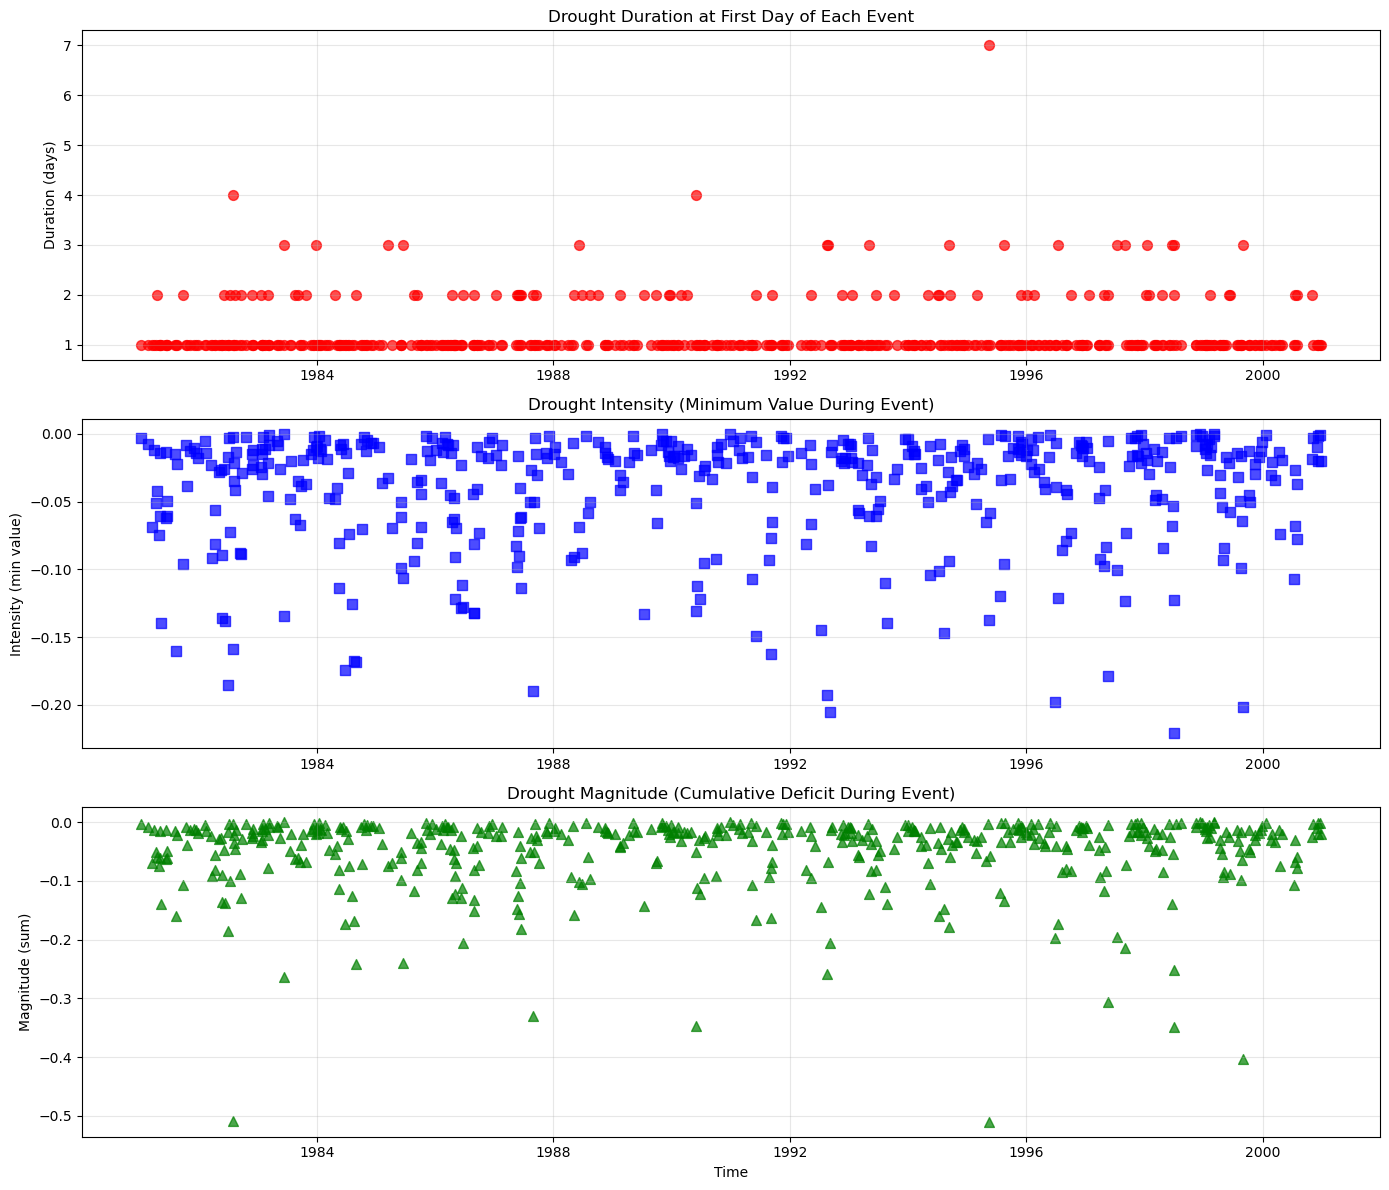

In [18]:
# Visualize all three drought metrics for a single location
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Get a single location
loc_duration = drought_duration.isel(x=110, y=230)
loc_intensity = drought_intensity.isel(x=110, y=230)
loc_magnitude = drought_magnitude.isel(x=110, y=230)

# Convert time for plotting
time_vals = pd.to_datetime([str(t) for t in loc_duration.time.values])

# Plot 1: Duration
mask_non_nan = ~np.isnan(loc_duration.values)
axes[0].scatter(time_vals[mask_non_nan], loc_duration.values[mask_non_nan], 
                alpha=0.7, s=50, c='red', marker='o')
axes[0].set_ylabel('Duration (days)')
axes[0].set_title('Drought Duration at First Day of Each Event')
axes[0].grid(True, alpha=0.3)

# Plot 2: Intensity (minimum value)
mask_non_nan = ~np.isnan(loc_intensity.values)
axes[1].scatter(time_vals[mask_non_nan], loc_intensity.values[mask_non_nan], 
                alpha=0.7, s=50, c='blue', marker='s')
axes[1].set_ylabel('Intensity (min value)')
axes[1].set_title('Drought Intensity (Minimum Value During Event)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Magnitude (sum)
mask_non_nan = ~np.isnan(loc_magnitude.values)
axes[2].scatter(time_vals[mask_non_nan], loc_magnitude.values[mask_non_nan], 
                alpha=0.7, s=50, c='green', marker='^')
axes[2].set_ylabel('Magnitude (sum)')
axes[2].set_xlabel('Time')
axes[2].set_title('Drought Magnitude (Cumulative Deficit During Event)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

In [34]:
# Add the drought mask to the merged metrics dataset
merged_metrics['mask'] = drought_mask

# Clear any existing attributes that might cause issues
merged_metrics.attrs.clear()

# Add global attributes
merged_metrics.attrs['resource'] = resource
merged_metrics.attrs['module'] = module
merged_metrics.attrs['domain'] = domain
merged_metrics.attrs['variable'] = variable
merged_metrics.attrs['simulation'] = simulation
merged_metrics.attrs['reference_gwl'] = float(reference_gwl)
merged_metrics.attrs['description'] = 'Drought event metrics: duration, intensity (min value), and magnitude (sum)'

# Assign to drought_metrics for saving
drought_metrics = merged_metrics

print("Drought metrics Dataset:")
print(drought_metrics)

Drought metrics Dataset:
<xarray.Dataset> Size: 12GB
Dimensions:            (y: 320, x: 250, time: 7300)
Coordinates:
    year               (time) int32 29kB 1981 1981 1981 1981 ... 2000 2000 2000
    dayofyear          (time) int32 29kB 1 2 3 4 5 6 ... 360 361 362 363 364 365
  * time               (time) object 58kB 1981-01-01 00:00:00 ... 2000-12-31 ...
    landmask           (y, x) float32 320kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 320kB 23.35 23.39 23.43 ... 56.42 56.46
    lon                (y, x) float32 320kB -116.5 -116.4 ... -111.6 -111.5
  * y                  (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
  * x                  (x) float64 2kB -4.638e+06 -4.629e+06 ... -2.397e+06
    Lambert_Conformal  int32 4B 1
    quantile           float64 8B 0.1
Data variables:
    duration           (y, x, time) float32 2GB nan nan nan nan ... nan nan nan
    intensity          (y, x, time) float32 2GB nan nan nan nan ... nan nan nan
    mag

In [35]:
drought_metrics

<xarray.Dataset> Size: 12GB
Dimensions:            (y: 320, x: 250, time: 7300)
Coordinates:
    year               (time) int32 29kB 1981 1981 1981 1981 ... 2000 2000 2000
    dayofyear          (time) int32 29kB 1 2 3 4 5 6 ... 360 361 362 363 364 365
  * time               (time) object 58kB 1981-01-01 00:00:00 ... 2000-12-31 ...
    landmask           (y, x) float32 320kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 320kB 23.35 23.39 23.43 ... 56.42 56.46
    lon                (y, x) float32 320kB -116.5 -116.4 ... -111.6 -111.5
  * y                  (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
  * x                  (x) float64 2kB -4.638e+06 -4.629e+06 ... -2.397e+06
    Lambert_Conformal  int32 4B 1
    quantile           float64 8B 0.1
Data variables:
    duration           (y, x, time) float32 2GB nan nan nan nan ... nan nan nan
    intensity          (y, x, time) float32 2GB nan nan nan nan ... nan nan nan
    magnitude          (y, x, time) float32 2GB nan nan nan nan ... nan nan nan
    mask               (y, x, time) int64 5GB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    resource:       pv
    module:         utility
    domain:         d02
    variable:       cf
    simulation:     taiesm1
    reference_gwl:  0.8
    description:    Drought event metrics: duration, intensity (min value), a...

In [29]:
drought_metrics.attrs.clear()

In [37]:
# Save the merged drought metrics with detailed metadata
output_file = f"../data/drought_masks/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_drought_mask_metrics.nc"

# Explicitly set encoding for all variables to avoid int64 overflow issues
encoding = {
    'duration': {'dtype': 'float32', '_FillValue': np.nan},
    'intensity': {'dtype': 'float32', '_FillValue': np.nan},
    'magnitude': {'dtype': 'float32', '_FillValue': np.nan},
    'mask': {'dtype': 'int32'}  # Convert int64 to int32 for NetCDF3 compatibility
}

print(f"Saving drought metrics to: {output_file}")
print(f"Total processing time: {total_elapsed:.2f} seconds ({total_elapsed/60:.2f} minutes)")

# Use NetCDF4 format to avoid int32 limitations
drought_metrics.to_netcdf(output_file, encoding=encoding, format='NETCDF4')

print(f"Successfully saved drought metrics!")
print(f"\nFile: {output_file}")
print(f"Size: {os.path.getsize(output_file) / 1e9:.2f} GB")


Saving drought metrics to: ../data/drought_masks/pv_utility_d02_cf_taiesm1_gwlref0.8_drought_mask_metrics.nc
Total processing time: 193.07 seconds (3.22 minutes)
Successfully saved drought metrics!

File: ../data/drought_masks/pv_utility_d02_cf_taiesm1_gwlref0.8_drought_mask_metrics.nc
Size: 9.35 GB
Successfully saved drought metrics!

File: ../data/drought_masks/pv_utility_d02_cf_taiesm1_gwlref0.8_drought_mask_metrics.nc
Size: 9.35 GB


In [38]:
# Optional: Remove temporary chunk files after successful merge
CLEANUP_CHUNKS = True  # Set to True to delete chunk files after merging

if CLEANUP_CHUNKS:
    import shutil
    print(f"Cleaning up temporary chunk files in {chunk_dir}/")
    shutil.rmtree(chunk_dir)
    print(f"Removed {len(chunk_files)} chunk files")
else:
    print(f"Keeping chunk files in {chunk_dir}/ (set CLEANUP_CHUNKS=True to remove)")

Cleaning up temporary chunk files in ../data/drought_masks/chunks/pv_utility_d02_cf_taiesm1_gwlref0.8/
Removed 3 chunk files


### Optional: Clean up temporary chunk files

## Interactive spatial visualization of drought mask

In [ ]:
# from ipywidgets import interact, IntSlider
# import matplotlib.pyplot as plt

# def plot_drought_mask_timestep(time_idx):
#     """Plot the spatial drought mask for a given time index"""
#     fig, ax = plt.subplots(figsize=(10, 8))
    
#     # Get the drought mask at this time step
#     mask_slice = drought_mask.isel(time=time_idx)
    
#     # Plot
#     im = ax.pcolormesh(
#         mask_slice.x, 
#         mask_slice.y, 
#         mask_slice.values,
#         cmap='RdYlBu_r',
#         vmin=0,
#         vmax=1,
#         shading='auto'
#     )
    
#     # Get the time value
#     time_val = drought_mask.time.values[time_idx]
    
#     ax.set_title(f'Drought Mask - Time: {time_val}', fontsize=14)
#     ax.set_xlabel('X coordinate')
#     ax.set_ylabel('Y coordinate')
#     ax.set_aspect('equal')
    
#     # Add colorbar
#     cbar = plt.colorbar(im, ax=ax)
#     cbar.set_label('Drought (1) / No Drought (0)', rotation=270, labelpad=20)
    
#     plt.tight_layout()
#     plt.show()

# # Create interactive slider
# n_times = len(drought_mask.time)
# time_slider = IntSlider(
#     min=0, 
#     max=n_times-1, 
#     step=1, 
#     value=0,
#     description='Time step:',
#     continuous_update=False
# )

# interact(plot_drought_mask_timestep, time_idx=time_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time step:', max=43069), Output…

<function __main__.plot_drought_mask_timestep(time_idx)>